In [4]:
%run import.py

%run cv_plots.py

# Model Evauation and Improvement #

So far to evaluate our supervised model we have split our data into training and test data, built the model on the training set and evaluated it on the test set using the score method. Here is an example of that process:

In [5]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
# create a synthetic dataset
X, y = make_blobs(random_state=0)
# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) # instantiate a model and fit it to the training set
logreg = LogisticRegression().fit(X_train, y_train)
# evaluate the model on the test set
print("Test set score: {:.2f}".format(logreg.score(X_test, y_test)))


Test set score: 0.88


The reason we have split our data is to measure how well our model genralizes to new unseen data. we are interested on how well our model can make predictions on data not observed in the training set. A more robust way to to asses generalization is through cross-validation.

### Cross-Validation ###
 cross-validation is a statistical method to evaluate model generalization preformance that is more stable and thorough than using just training and test sets. In cross-validation the data is instead split repeatedly and multiple models are trained. The most common version of cross-validation is *k-fold cross-validation*, where k is a user defined number usually 5 or 10. when using k-fold cross-validation the data is partitioned into k parts of aproximately equal size colled *folds*. Then a sequence of models is trained. The first model is trained using the first fold aas the test set and the other k-1 sets as the training set and the accuracy is assesed. Then another model is built using the second fold as the test set and the first and 3rd-kth sets as the training set. The accuracy of this model is evaluated and the process is repeated until each fold has been used as the test set. in the end we get k accuracy values for each fold. We can issistate the process with 5 folds as follows:

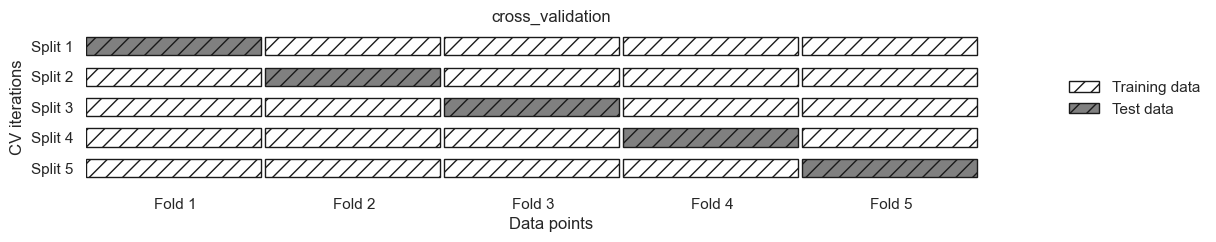

In [6]:
plot_cross_validation()

Cross-validation in scikit-learn uses the `cross_val_score` funtion from the `model_selection` module. The inputs to the function are the model you want to evaluate the training data and the ground truth labels. Lets look at cross-validation with the iris dataset using logistic regression: 

In [7]:
from sklearn.model_selection import cross_val_score 
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
iris = load_iris()
logreg = LogisticRegression(max_iter=1000000)
scores = cross_val_score(logreg, iris.data, iris.target) 
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96666667 1.         0.93333333 0.96666667 1.        ]


In [8]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))
print("Standard Deviation cross-validation score: {:.2f}".format(scores.std()))

Average cross-validation score: 0.97
Standard Deviation cross-validation score: 0.02


Here we can see that the average accuracy that we can obtain is 97% with a standard deviation of 2%. This high standard deviation could imply that moderl is dependant on how we choose folds or could be due to the small size of the dataset.

There is a second function we can use for cross-validation it is called `cross_validate`. This function has the same interface but returns a dictionary along with training and testing times for each slpit:

In [9]:
from sklearn.model_selection import cross_validate
res = cross_validate(logreg, iris.data, iris.target, cv=5,return_train_score=True)
display(res)

{'fit_time': array([0.01571965, 0.02104974, 0.01400924, 0.        , 0.        ]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([0.96666667, 1.        , 0.93333333, 0.96666667, 1.        ]),
 'train_score': array([0.96666667, 0.96666667, 0.98333333, 0.98333333, 0.975     ])}

We can display this in a data frame as follows:

In [10]:
res_df = pd.DataFrame(res)
display(res_df)
print("Mean times and scores:\n", res_df.mean())

,fit_time,score_time,test_score,train_score
0,0.015720,0.0,0.966667,0.966667
1,0.021050,0.0,1.000000,0.966667
2,0.014009,0.0,0.933333,0.983333
3,0.000000,0.0,0.966667,0.983333
4,0.000000,0.0,1.000000,0.975000


Mean times and scores:
 fit_time       0.010156
score_time     0.000000
test_score     0.973333
train_score    0.975000
dtype: float64


Cross-validation is better than just splitting into training and test sets because we could get lucky or unlucky when getting a traing or test set and have unrealestivcally low or high accuracy becasue of this. Another advatange of cross-validation is that it can provide information on the sensitivity to the training and test sets and give an idea of worst and best case accuracy.Lastly cross-validation allows us to use our data more efficently. With 5 fold cross-validation we are trainning on 80% of the data and with 10 fold cross-validation we are training on 90% of the data. More data usually results in more accurate models.

The main disadvantage of cross-validation is increases computational time. We are now training k models instead of just one and therfore will be k times slower than just training a single model. Remeber cross-validation does not build the final model but evalutes how well a given algorithm will generalize when trained on a given set of data.

### Stratified k-Fold Cross-Validation and Other Strategies ###

splitting the dtataset into k folds by srating with the first one k-th part of the data may not alwayts be a good idea.Lets look at the iris dataset:

In [11]:
from sklearn.datasets import load_iris
iris = load_iris()
print("Iris labels:\n{}".format(iris.target))

Iris labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


Here we can see that the data is ordered by the labels. The first third of the data is labeled calss 0 the second third class 1 and the last thrid labeld class 2. If we did only a 3 fold cross-validation on this we would get 0% accuracy (why?). One strategy  is to use stratifies k-fold cross-validation insstead where each fold has a simailar represntation to the whole data set. For classification problems ski-kit learn uses stratifiedk-fold crossvalidation and for regression models it uses k-fold cross-validation

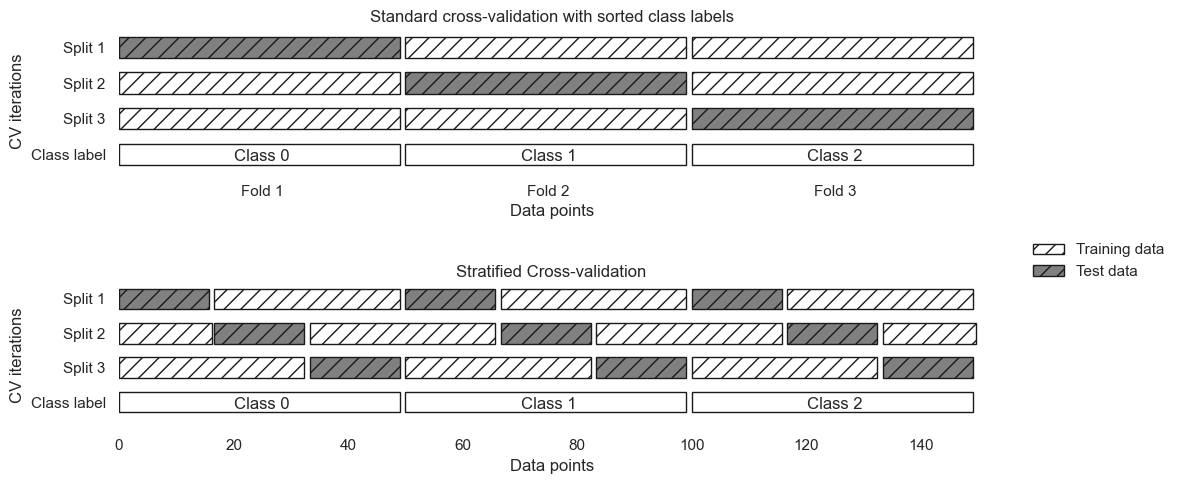

In [12]:
plot_stratified_cross_validation()

## Controling cross-validation ##

scikit learn contains a method to contol the folds thar are passsed onto the `cross_val_score` function. Say we want to use standard k-fold crossvalidation on the iris dataset instead of stratified. To do this we can inport the KFold splitter calss from the model selection module:

In [13]:
from sklearn.model_selection import KFold 
kfold = KFold(n_splits=5)

Now we pass the kfold fplitter object as the cv parameter to  `cross_val_score`:

In [14]:
print("Cross-validation scores:\n{}".format( cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[1.         1.         0.86666667 0.93333333 0.83333333]


We can use this idea to show why 3 folds is a bad idea for the iris dataset:

In [15]:
kfold = KFold(n_splits=3) 
print("Cross-validation scores:\n{}".format(cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[0. 0. 0.]


Another method of cross-validation is called leave one out. This is a methid that keeps one point as the test set and trains on the rest of the data. This can be very time consuming but can give better estimtes on small datasets:

In [20]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo) 
print("Number of cv iterations: ", len(scores))
print("Mean accuracy: {:.2f}".format(scores.mean()))
print("Standard Deviation accuracy: {:.2f}".format(scores.std()))

Number of cv iterations:  150
Mean accuracy: 0.97
Standard Deviation accuracy: 0.18


One last mehtod we will talk about is shuffle-split cross-validation. Here each split samples `train_size` number of points for the training set and `test_size` many (disjoint) points for the test size. This splitting is done `n_split` times. This is visulized in the graphic below with a training set of 5 point a test set of 2 points and 4 repitions:

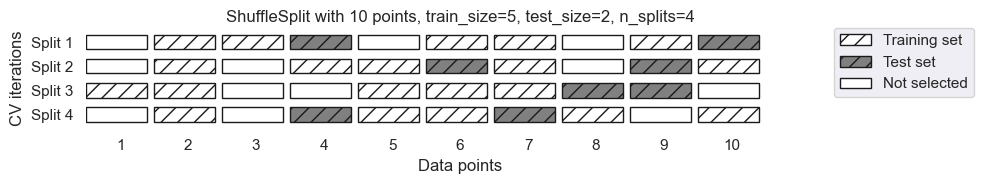

In [17]:
plot_shuffle_split()

Here we can look at the results of the iris dataset when splitting the data in half 10 times:

In [18]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10) 
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split) 
print("Cross-validation scores:\n{}".format(scores))
print("Average Cross-validation score:\n{}".format(np.mean(scores)))
print("Standard Deviation of Cross-validation score:\n{}".format(np.std(scores)))

Cross-validation scores:
[0.94666667 0.98666667 0.90666667 0.94666667 0.98666667 0.96
 0.96       0.93333333 0.94666667 0.94666667]
Average Cross-validation score:
0.9520000000000002
Standard Deviation of Cross-validation score:
0.022469732728470304
